In [18]:
from matplotlib import pyplot as plt
from slab import datamanagement
from slab import dsfit
from slab import dataanalysis
from slab.datamanagement import SlabFile
from numpy import *
from numpy import linalg
%matplotlib inline
%config InlineBackend.figure_format='retina'
from tabulate import tabulate

data_dir = r'S:\_Data\160216 -M007 Trident Hybrid Coupler setup\data'
exp_dir = r'S:\_Data\160216 -M007 Trident Hybrid Coupler setup\experiment'
nbfig_dir = r'C:\Users\slab\Google Drive\grad school\schuster lab\Analysis\IPython Notebooks\Figures'

sys.path.append(exp_dir)
sys.path.append(r'C:\Users\slab\Google Drive\grad school\schuster lab')
from data_cache import dataCacheProxy
from Analysis.Modules import common, fit, anal, static_surface, trap_analysis

Fit results for y = a0 + a1*x + ... with 1 sigma confidence intervals
---------------------------------------------------------------------
a0 = -6.73718209829e-05 +/- 0.000138817854035
a1 = 0.24326228611 +/- 0.000479735744487


(-1.3999999999999999, 1.3999999999999999)

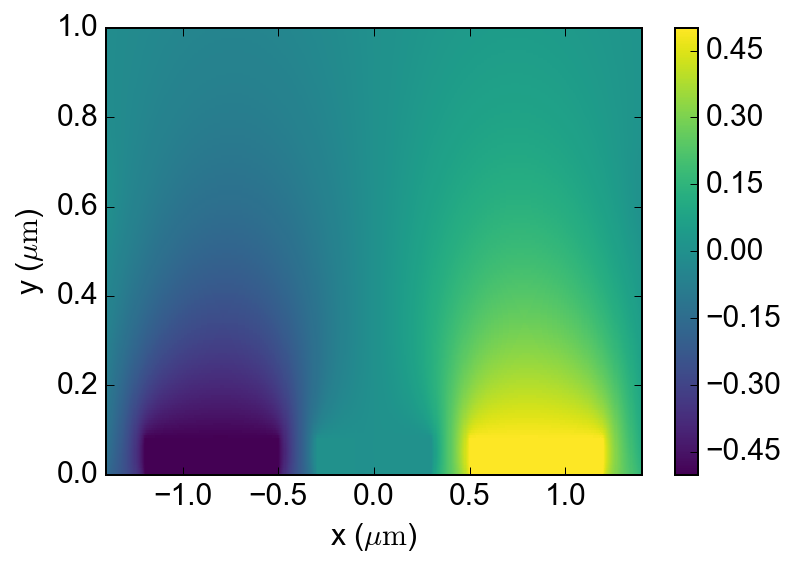

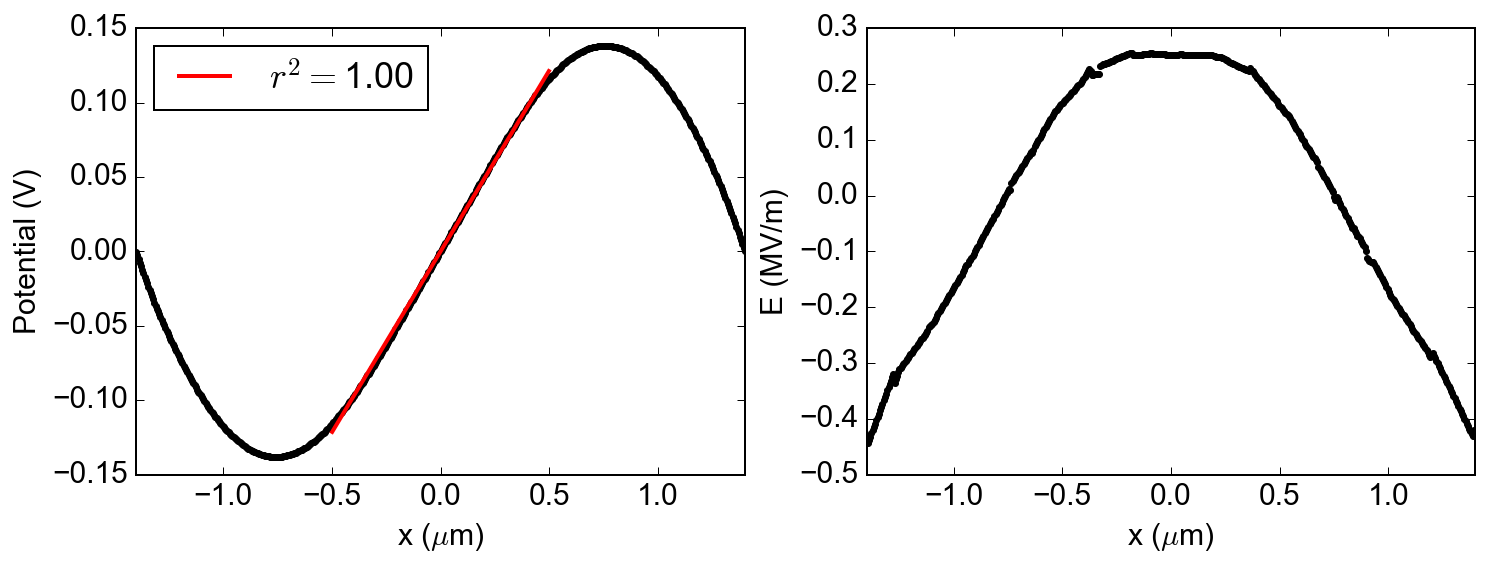

In [19]:
base_path = r'S:\Gerwin\Electron on helium\Maxwell\M016 Sweet Spot Exploration\0.1 pct accuracy'
x, y, V = static_surface.load_maxwell_data(os.path.join(base_path, "XZ_trap_diffmode.fld"), do_log=False, 
                                           figsize=(6.,4.), plot_axes='xz', cmap=plt.cm.viridis, ylim=(0, 1))

xdata = x[:,0]*1E6
ydata = V[:, common.find_nearest(y, 0.6E-6)]
fitdomain = (-0.5, +0.5)
fr, ferr = dsfit.fitpoly(xdata, ydata, fitparams=[0, 2E5], domain=fitdomain)
xfit, yfit = dsfit.selectdomain(xdata, dsfit.polyfunc_v2(xdata, *fr), fitdomain)
xdata_cropped, ydata_cropped = dsfit.selectdomain(xdata, ydata, fitdomain)
gof = dsfit.get_rsquare(ydata_cropped, yfit)

plt.figure(figsize=(12.,4.))
plt.subplot(121)
plt.plot(xdata, ydata, '.k')
plt.plot(xfit, yfit, '-r', lw=2.0, label='$r^2 = $%.2f'%(gof))
plt.xlabel('x ($\mu$m)')
plt.ylabel('Potential (V)')
plt.xlim(min(x[:,0]*1E6), max(x[:,0]*1E6))
plt.legend(loc=0)

plt.subplot(122)
plt.plot(x[:-1,0]*1E6, 1E-6*diff(V[:, common.find_nearest(y, 0.6E-6)])/diff(x[:,0]), '.k')
plt.xlabel('x ($\mu$m)')
plt.ylabel('E (MV/m)')
plt.xlim(min(x[:,0]*1E6), max(x[:,0]*1E6))

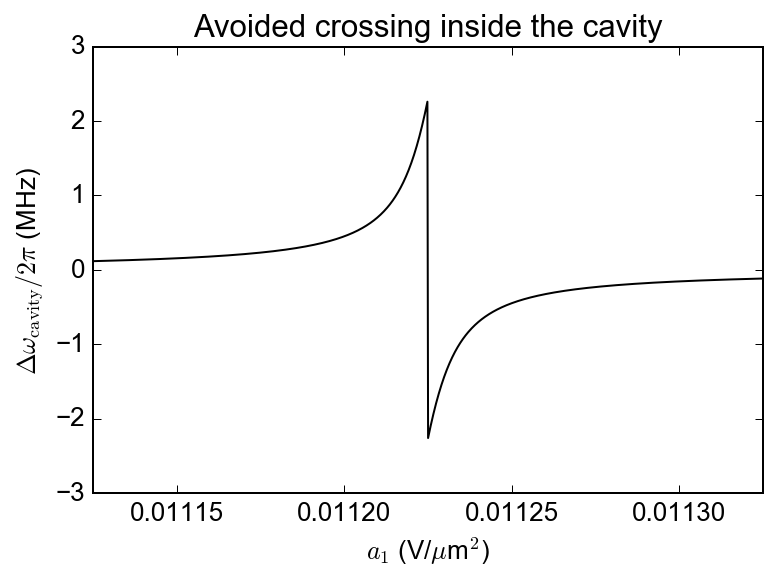

In [20]:
c = trap_analysis.get_constants()
omega0 = 2*pi*10E9
Z = 50. 
P = -70 # Power inside the cavity
Q = 1E4 # Q of the microwave cavity
L = Z/omega0
a1_resonance = c['m_e']*omega0**2/(2*c['e'])
a1s = linspace(a1_resonance-1E8, a1_resonance+1E8, 1E3) # Quadratic component of the DC potential in V/m**2

N = common.get_noof_photons_in_cavity(P, omega0/(2*pi), Q)
voltage_scaling = sqrt(N) * sqrt(1.055E-34 * omega0**2 * Z/2.)
beta = voltage_scaling * fr[1] * 1E6 # Linear component of the RF potential in V/m

eigenfrequencies = list()

for a1 in a1s: 
    Mat = array([[omega0**2, c['e'] * omega0**2 * beta], 
                 [c['e'] * omega0**2 * L * beta/c['m_e'], 2 * c['e'] * a1/c['m_e']]])

    EVals = linalg.eigvals(Mat)
    eigenfrequencies.append(sqrt(EVals)/(2*pi))

eigenfrequencies = array(eigenfrequencies)
    
plt.figure(figsize=(6.,4.))
common.configure_axes(13)
plt.plot(a1s/1E12, (eigenfrequencies[:,0]-omega0/(2*pi))/1E6, '-k')

plt.ylabel('$\Delta \omega_{\mathrm{cavity}}/2\pi$ (MHz)')
plt.xlabel('$a_1$ (V/$\mu$m$^2$)')
plt.xlim(min(a1s)/1E12, max(a1s)/1E12)
plt.title("Avoided crossing inside the cavity")